In [1]:
import geopandas as gpd
import pickle
from sklearn.neighbors import BallTree
import numpy as np
from shapely.geometry import LineString
%matplotlib inline
import matplotlib.pyplot as plt

root_path = "D:/GeoData/"
Main_CRS = "EPSG:27700"

In [2]:
def load_obj(name ):
    with open(root_path + 'WorkingData/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
Mapset = load_obj("Clipped5k_Euston")

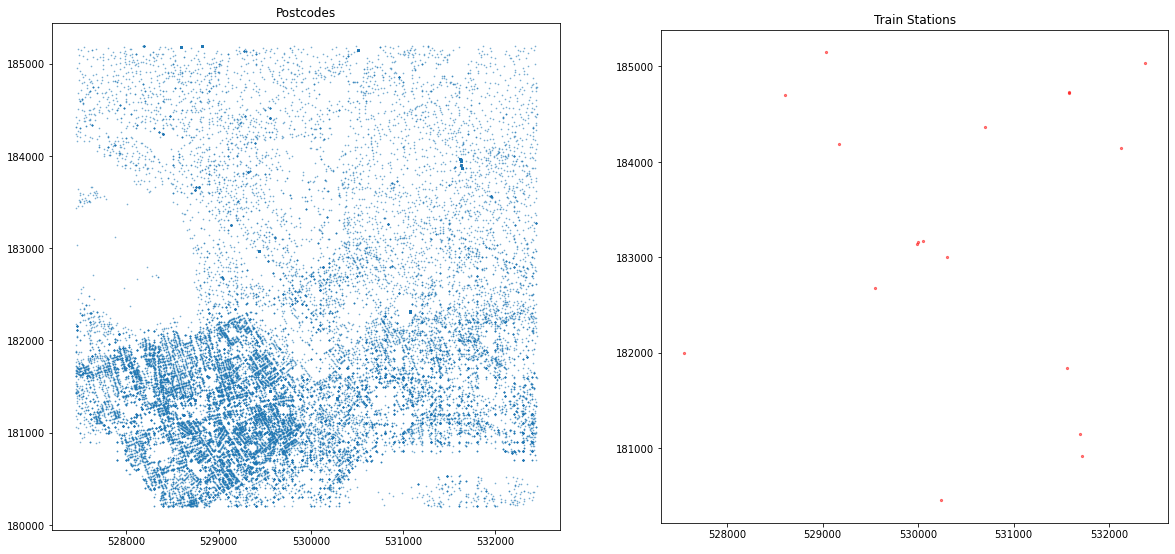

In [4]:
fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
#Plot postcodes
Mapset['NSPL_gdf'].plot(ax=axes[0],markersize=0.5, alpha=0.5)
axes[0].set_title('Postcodes')

#Plot Train Stations
Mapset['RailwayStations'].plot(ax=axes[1], markersize=5, alpha=0.5, color='red')
axes[1].set_title('Train Stations');

In [5]:
def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
     # removed metric since the default is euclidian (what my coordinates use)
    tree = BallTree(candidates, leaf_size=15)

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)

In [6]:
def nearest_neighbor(left_gdf, right_gdf, right_col_name, outname, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    """
    
    #Some of the data frames will have empty geometries so this will drop them
    left_gdf = left_gdf[~(left_gdf.is_empty)]
    right_gdf = right_gdf[~(right_gdf.is_empty)]
    
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    left = left_gdf.copy().reset_index(drop=True)
    right = right_gdf.copy().reset_index(drop=True)
    
    left_points = np.array(left[left_geom_col].apply(lambda geom: (geom.x, geom.y)).to_list())
    right_points = np.array(right[right_geom_col].apply(lambda geom: (geom.x, geom.y)).to_list())

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_points, candidates=right_points)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    left_index = left_gdf.index
    closest_points = closest_points.reset_index(drop=True)
    closest_points = closest_points.set_index(left_index)
    
    #Select the columns to keep in the output dataframe
    keep = [right_col_name, 'geometry']
    closest_points = closest_points[keep]
    
    suffix = "Nearest_" + outname
    
    closest_points = closest_points.rename(columns={right_col_name: suffix + '_Name'})
    closest_points = closest_points.rename(columns={'geometry': suffix + '_Geometry'})
    
    # Add distance if requested
    if return_dist:
        closest_points[suffix + '_Distance'] = dist

    return closest_points

In [7]:
Nearest_TrainStation = nearest_neighbor(Mapset['NSPL_gdf'], 
                                        Mapset['RailwayStations'], 
                                        "StationName", 
                                        "TrainStation", 
                                        return_dist=True)

# And the result looks like ..
Nearest_TrainStation

,Nearest_TrainStation_Name,Nearest_TrainStation_Geometry,Nearest_TrainStation_Distance
480363,London Kings Cross Rail Station,POINT (530300.000 183000.000),516.364213
757939,Farringdon (London) Rail Station,POINT (531560.000 181840.000),691.234403
757940,City Thameslink Rail Station,POINT (531690.000 181150.000),344.383507
757941,Farringdon (London) Rail Station,POINT (531560.000 181840.000),681.687612
757942,Farringdon (London) Rail Station,POINT (531560.000 181840.000),590.931468
...,...,...,...
2531230,London Charing Cross Rail Station,POINT (530235.000 180455.000),926.244568
2531231,London Charing Cross Rail Station,POINT (530235.000 180455.000),926.244568
2531232,Farringdon (London) Rail Station,POINT (531560.000 181840.000),681.687612
2531234,London Charing Cross Rail Station,POINT (530235.000 180455.000),926.244568


In [8]:
# Merge the datasets by index (for this, it is good to use '.join()' -function)
Mapset['NSPL_gdf'] = Mapset['NSPL_gdf'].join(Nearest_TrainStation)

C:\Users\richa\Anaconda3\envs\LandReg_py\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


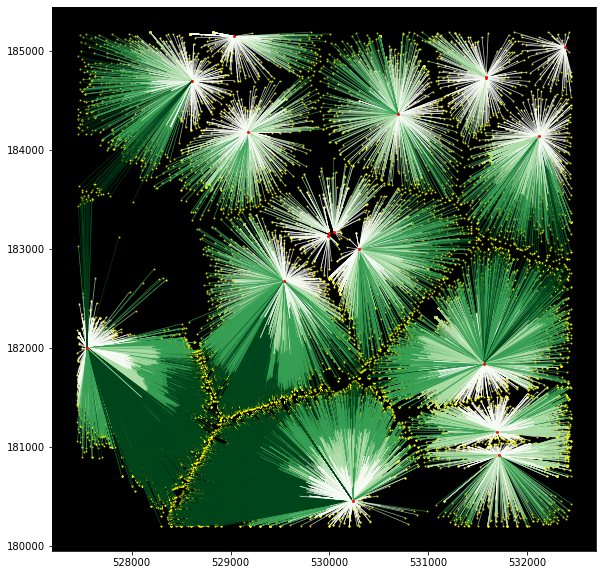

In [9]:
# Create a link (LineString) between building and stop points
Mapset['NSPL_gdf']['link'] = Mapset['NSPL_gdf'].apply(lambda row: LineString([row['geometry'], row['Nearest_TrainStation_Geometry']]), axis=1)

# Set link as the active geometry
Postcode_links = Mapset['NSPL_gdf'].copy()
Postcode_links = Postcode_links.set_geometry('link')

# Plot the connecting links between buildings and stops and color them based on distance
ax = Postcode_links.plot(column='Nearest_TrainStation_Distance', cmap='Greens', scheme='quantiles', k=4, alpha=0.8, lw=0.7, figsize=(13, 10))
ax = Mapset['NSPL_gdf'].plot(ax=ax, color='yellow', markersize=1, alpha=0.7)
ax = Mapset['RailwayStations'].plot(ax=ax, markersize=4, marker='o', color='red', alpha=0.9, zorder=3)

# Set map background color to black, which helps with contrast
ax.set_facecolor('black')

plt.savefig("Images/" + 'NearestNeighbour.png',dpi=300)

In [11]:
Nearest_BusStop = nearest_neighbor(Mapset['NSPL_gdf'], 
                                        Mapset['BusStops'], 
                                        "CommonName", 
                                        "BusStop", 
                                        return_dist=True)

Mapset['NSPL_gdf'] = Mapset['NSPL_gdf'].join(Nearest_BusStop)

In [ ]:
All_Maps = load_obj("All_Maps")

In [15]:
import time
start = time.time()
Nearest_TrainStation = nearest_neighbor(All_Maps['NSPL_gdf'], 
                                        All_Maps['RailwayStations'], 
                                        "StationName", 
                                        "TrainStation", 
                                        return_dist=True)
end = time.time()
Elapsed_Time = end - start
Elapsed_Time

48.69259309768677

In [16]:
Nearest_TrainStation

,Nearest_TrainStation_Name,Nearest_TrainStation_Geometry,Nearest_TrainStation_Distance
0,Portlethen Rail Station,POINT (392420.000 796710.000),8341.129720
1,Portlethen Rail Station,POINT (392420.000 796710.000),8582.416035
2,Portlethen Rail Station,POINT (392420.000 796710.000),8571.733372
3,Portlethen Rail Station,POINT (392420.000 796710.000),8237.748479
4,Portlethen Rail Station,POINT (392420.000 796710.000),8886.174655
...,...,...,...
2651384,Wick Rail Station,POINT (336065.000 950885.000),189526.107724
2651385,Wick Rail Station,POINT (336065.000 950885.000),189622.263474
2651386,Wick Rail Station,POINT (336065.000 950885.000),190944.777946
2651387,Wick Rail Station,POINT (336065.000 950885.000),191111.262300


In [ ]:
#25%cpu
#2gb Ram

In [17]:
import time
start = time.time()
Nearest_BusStop = nearest_neighbor(All_Maps['NSPL_gdf'], 
                                    All_Maps['BusStops'], 
                                    "CommonName", 
                                    "BusStop", 
                                    return_dist=True)
end = time.time()
Elapsed_Time = end - start
Elapsed_Time

87.42475581169128